In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## 1. 📥 Daten laden

In [23]:
df_raw = pd.read_csv(r'C:\Users\Admin\OneDrive\bewerbung\neoom_ag\neoom_datascience_challenge_2025.csv', parse_dates=['Time'])
df_raw.head()

,Time,ENERGY_CHARGED,POWER_PRODUCTION,POWER_STORAGE,POWER_GRID,ENERGY_PRODUCED,POWER_CONSUMPTION_CALC,ENERGY_CONSUMED_CALC,ENERGY_EXPORTED,ENERGY_IMPORTED,ENERGY_DISCHARGED,DYNAMIC_CONSUMPTION_TARIFF
0,2024-10-12 00:00:00+00:00,0.0,0.0,0.0,11886.911901,24197960.0,11886.911906,92863954.0,2.850206e+09,71516200.0,0.0,8.7528
1,2024-10-12 00:15:00+00:00,0.0,0.0,0.0,11823.676030,24197960.0,11823.675997,92866874.0,2.850206e+09,71519120.0,0.0,8.7528
2,2024-10-12 00:30:00+00:00,0.0,0.0,0.0,11072.283899,24197960.0,11072.284124,92869634.0,2.850206e+09,71521880.0,0.0,8.7528
3,2024-10-12 00:45:00+00:00,0.0,0.0,0.0,10647.192637,24197960.0,10647.192722,92872234.0,2.850206e+09,71524480.0,0.0,8.7528
4,2024-10-12 01:00:00+00:00,0.0,0.0,0.0,11956.350025,24197960.0,11956.350176,92875282.0,2.850206e+09,71527528.0,0.0,8.5440


In [24]:
import pandas as pd

# 1) CSV neu einlesen  –  NUR parse_dates angeben
df = pd.read_csv(
    r"C:\Users\Admin\OneDrive\bewerbung\neoom_ag\neoom_datascience_challenge_2025.csv",
    parse_dates=['Time']          # 'Time' wird gleich als datetime erkannt
)

# 2) Einmal kontrollieren, ob die Spalte wirklich da ist
print("Spalten:", list(df.columns))      # hier siehst du 'Time'

# 3) 'Time' zum Index machen  (danach nicht mehr als Spalte vorhanden!)
df = df.set_index('Time').sort_index()

# 4) Index auf lokale Zone umstellen, TZ-Info beibehalten
df_local = df.tz_convert('Europe/Vienna')

# 5) Kontrolle
print(df_local.index.dtype)   # → datetime64[ns, Europe/Vienna]
print(df_local.head())


Spalten: ['Time', 'ENERGY_CHARGED', 'POWER_PRODUCTION', 'POWER_STORAGE', 'POWER_GRID', 'ENERGY_PRODUCED', 'POWER_CONSUMPTION_CALC', 'ENERGY_CONSUMED_CALC', 'ENERGY_EXPORTED', 'ENERGY_IMPORTED', 'ENERGY_DISCHARGED', 'DYNAMIC_CONSUMPTION_TARIFF']
datetime64[ns, Europe/Vienna]
                           ENERGY_CHARGED  POWER_PRODUCTION  POWER_STORAGE  \
Time                                                                         
2024-10-12 02:00:00+02:00             0.0               0.0            0.0   
2024-10-12 02:15:00+02:00             0.0               0.0            0.0   
2024-10-12 02:30:00+02:00             0.0               0.0            0.0   
2024-10-12 02:45:00+02:00             0.0               0.0            0.0   
2024-10-12 03:00:00+02:00             0.0               0.0            0.0   

                             POWER_GRID  ENERGY_PRODUCED  \
Time                                                       
2024-10-12 02:00:00+02:00  11886.911901       24197960.0  

In [25]:
df_save = df_local.copy()
df_save.index = df_save.index.tz_localize(None)   # TZ-Info abwerfen
df_save.to_excel("data_1.xlsx")



In [26]:
import pandas as pd



# --------------------------------- 1  CSV einlesen & sortieren --------------
df = (pd.read_csv("neoom_datascience_challenge_2025.csv", parse_dates=["Time"])
        .set_index("Time")
        .sort_index())                        # UTC-Index, chronologisch

# --------------------------------- 2  Verbrauch (Wh) rekonstruieren ----------
df["CONSUMED_RECALC"] = (
      df["ENERGY_IMPORTED"]
    + df["ENERGY_PRODUCED"]
    - df["ENERGY_EXPORTED"]          # Export abziehen
    # + df["ENERGY_DISCHARGED"]      # (0 Wh)
    # - df["ENERGY_CHARGED"]         # (0 Wh)
)

# --------------------------------- 3  KONSTANTEN Versatz ausgleichen ---------
#    (Differenz der allerersten Zeile)
shift = df["ENERGY_CONSUMED_CALC"].iat[0] - df["CONSUMED_RECALC"].iat[0]
df["CONSUMED_RECALC"] += shift

# --------------------------------- 4  Prüfen – jetzt 0 Wh Abweichung ---------
max_err = (df["ENERGY_CONSUMED_CALC"] - df["CONSUMED_RECALC"]).abs().max()
print("Maximale Abweichung:", max_err, "Wh")          # 0 Wh oder ≤ 1 Wh

# --------------------------------- 5  diff-Spalte & Excel-freundlicher Export
df["diff"] = df["CONSUMED_RECALC"] - df["ENERGY_CONSUMED_CALC"]

export = df.copy()
export.index = export.index.tz_localize(None)         # TZ-Angabe entfernen
export.to_csv("nachrechnen_1.csv", index=True, encoding="utf-8")



Maximale Abweichung: 759969.0 Wh


ERGEBNISSE: 
1. Dass in beiden Spalten ENERGY_CHARGED und ENERGY_DISCHARGED durchgängig 0 Wh steht, bedeutet:
Keine Batterienutzung: Die Speicher­einheit wurde während des gesamten Zeitraums weder aufgeladen noch entladen.

Statische Betriebsweise: Sowohl bei PV-Spitzen (wenn Überschuss­strom verfügbar gewesen wäre) als auch nachts (wenn günstige Tarife vorlagen) fand kein Verschieben von Energie in den Speicher statt.

Welche Vorteile hätte ein aktives Laden/Entladen?
Erhöhung der Eigenverbrauchs­quote:

Laden bei PV-Überschuss (wenn Sonne scheint und PV-Ertrag > Verbrauch)
Entladen bei Sonnenflaute (wenn PV < Verbrauch)
Mehr selbst genutzter Solarstrom, weniger Einspeisung zum Niedrig­tarif und weniger teurer Netzbezug.

Tarif­arbitrage:
Laden nachts zu günstigen Preisen (z. B. 0–6 Uhr, oft < 5 ct/kWh)
Entladen in den teuren Spitzen­stunden (z. B. 16–18 Uhr, > 20 ct/kWh)
→ Differenz zwischen Lade- und Entlade­preis ausnutzen, um Kosten zu sparen.

Peak-Shaving und Netz­entlastung
Entladen bei hohen Lastspitzen (Grundlast + unerwartete Verbrauchsspitzen)
→ Glättung der Bezugsleistung aus dem Netz, geringere Spitzenlast und potenziell niedrigere Netzentgelte.

Ausfallsicherung und Resilienz
Im Falle eines Netzausfalls könnte eine geladene Batterie kurzfristig wichtige Verbraucher versorgen.
→ Erhöhung der Versorgungssicherheit.

Flexibilität für erneuerbare Integration
Durch intelligentes Laden/Entladen kann der Eigenverbrauch weiter steigen und die Systemintegration von PV optimiert werden.
→ Weniger Blindleistung, stabileres Netzverhalten, bessere Bilanz für den Anlagenbetreiber.

Zusammenfassung:
Aktive Werte in ENERGY_CHARGED und ENERGY_DISCHARGED würden zeigen, dass der Kunde seine Batterie nutzt, um Solar­überschüsse einzuspeichern und Lastspitzen abzufangen. Das eröffnet ökonomische Möglichkeiten (Kosteneinsparung durch Arbitrage) und technische Vorteile (Peak-Shaving, Ausfallsicherheit, höhere Autarkie). In deinem Datensatz ist dieses Potenzial derzeit ungenutzt.

2. Was bedeutet ein positiver diff-Wert?
diff = CONSUMED_RECALC – ENERGY_CONSUMED_CALC

Jeder konstante Block in diff zeigt dir einen Reset-Abschnitt. Die positive Differenz offenbart, dass  in diesem Intervall durch das Zurücksetzen des Zählers Energie „übersehen“ wurde.

Für einen PV-Erzeugungs-Forecast sind die Zähler-Resets im Consumption-Kanal völlig irrelevant

3. Lokalzeit (Europe/Vienna) bevor du hour, dayofyear, sin_hour etc. baust

So lernt das Modell die echten Tageszeiten und berücksichtigt auch, dass der 27. Okt. 25 h hat. Ohne TZ-Convert würde das Modell konstant „UTC-Stunden“ beibringen, was bei einer PV-Forecast suboptimal ist.
________________________________________


## 2. 📈 Visualisierungen

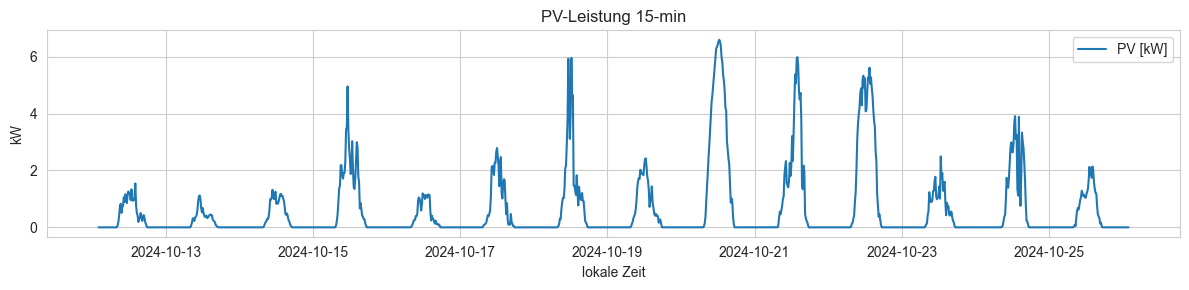

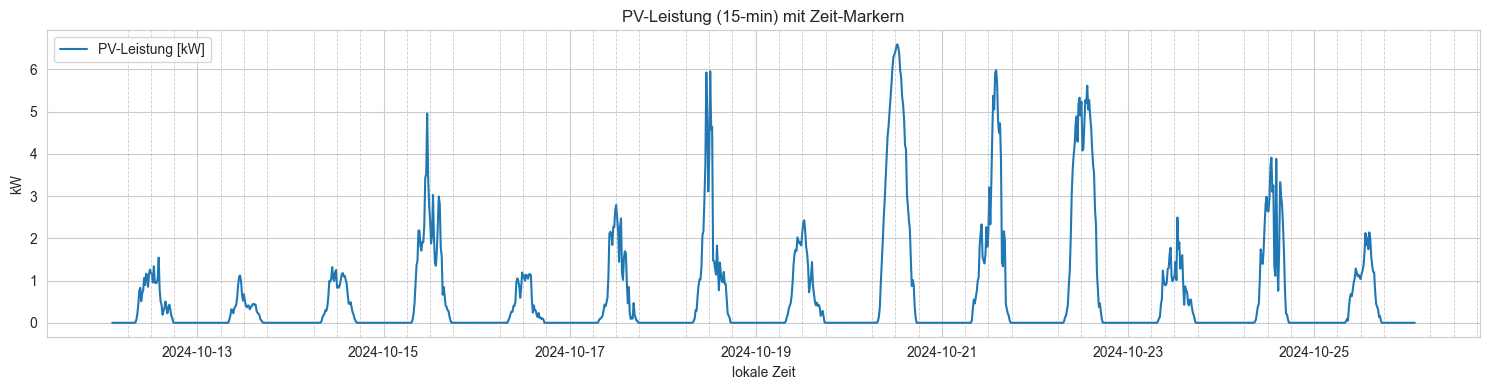

In [ ]:
#15-Min-Linienplot PV, Verbrauch, Netzfluss, Preis (rechte Achse)

plt.rcParams.update({"figure.autolayout": True, "axes.grid": True})
sns.set_style("whitegrid")

# --- Datei einlesen (UTC) -------------------------------------
csv = "neoom_datascience_challenge_2025.csv"
df = (
    pd.read_csv(csv, parse_dates=["Time"])
      .set_index("Time")
      .sort_index()                      # UTC-Index
)

# --- zusätzliche Spalten / lokale Zeit ------------------------
df_local = df.tz_convert("Europe/Vienna")

df["cons_kWh"]   = df["POWER_CONSUMPTION_CALC"] * 0.25 / 1000
df["import_kWh"] = df["POWER_GRID"].clip(lower=0) * 0.25 / 1000
df["export_kWh"] = df["POWER_GRID"].clip(upper=0).abs() * 0.25 / 1000
df["hour"] = df.index.hour
df["dow"]  = df.index.dayofweek            # 0=Mo … 6=So
# %%
df_local = df.tz_convert("Europe/Vienna")

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(df_local.index, df_local["POWER_PRODUCTION"]/1000, label="PV [kW]")
ax.set_ylabel("kW"); ax.set_xlabel("lokale Zeit")
ax.legend(); ax.set_title("PV-Leistung 15-min")
plt.show()

# %%  ─ PV-Plot mit Leitlinien
fig, ax1 = plt.subplots(figsize=(15,4))
ax1.plot(df_local.index, df_local["POWER_PRODUCTION"]/1000,
         label="PV-Leistung [kW]")

# ► vertikale Leitlinien pro Tag
for d in pd.date_range(df_local.index.date.min(),
                       df_local.index.date.max(),
                       freq="D"):
    for h in (6, 12, 18):                        # 07:00, 13:00, 18:00
        ts = pd.Timestamp(d).tz_localize("Europe/Vienna") + pd.Timedelta(hours=h)
        ax1.axvline(ts, color="gray", lw=0.6, ls="--", alpha=.4)

ax1.set_ylabel("kW"); ax1.set_xlabel("lokale Zeit")
ax1.set_title("PV-Leistung (15-min) mit Zeit-Markern")
ax1.legend(loc="upper left")
plt.show()


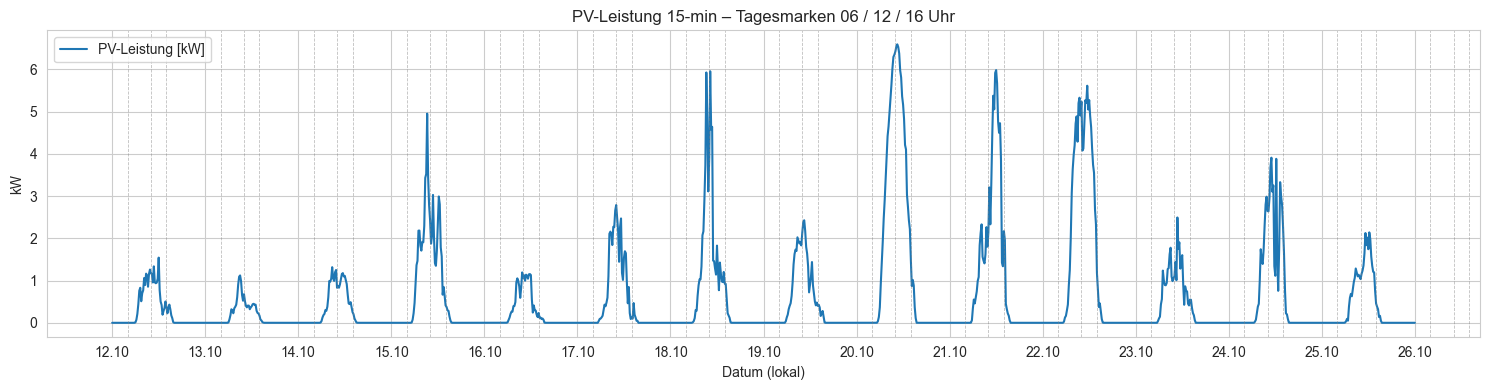

In [101]:
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,4))

# --- Kurve ----------------------------------------------------
ax.plot(
    df_local.index,                       # Europe/Vienna-Index
    df_local["POWER_PRODUCTION"]/1000,
    label="PV-Leistung [kW]"
)

# --- X-Achse: Tick pro Tag ------------------------------------
ax.xaxis.set_major_locator(mdates.DayLocator())            # 1-Tages-Raster
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

# --- Vertikale Linien 06 / 12 / 16 Uhr ------------------------
for day in pd.date_range(df_local.index.date.min(),
                         df_local.index.date.max(),
                         freq="D"):
    base = pd.Timestamp(day).tz_localize("Europe/Vienna")
    for h in (6, 12, 16):
        ax.axvline(base + pd.Timedelta(hours=h),
                   color="gray", lw=.6, ls="--", alpha=.5)

# --- Beschriftung & Format ------------------------------------
ax.set_xlabel("Datum (lokal)"); ax.set_ylabel("kW")
ax.set_title("PV-Leistung 15-min – Tagesmarken 06 / 12 / 16 Uhr")
ax.legend(loc="upper left")

plt.show()

Kurz-Analyse des täglichen PV-Profils

Beobachtung	Interpretation / Schluss:
Glockenkurve mit Maximum um 12 Uhr	Süd- oder leicht Süd-West-Ausrichtung, keine Ost/West-Strings.
Spitzenleistung ~ 6 kW (mehrfach exakt erreicht)	
Bestätigt 6,5 kWp-Nennleistung ohne nennenswertes Clipping; Modulleistung und Wechselrichter sind gut abgestimmt.
Morgendlicher Anstieg verschiebt sich von 07:00 auf 07:30:	
Jahreszeitlicher Sonnenaufgang: Ende Oktober geht die Sonne später auf.
Abendlicher Abfall von 17:30 auf 17:00 Uhr:
Entsprechende Verkürzung der Tageslänge belegt korrekte lokale Zeitachse (ME(S)Z).
Hohe Tages-Variabilität (Plateaus vs. Wolkentage)	Wetter bestimmt Ertrag stark—historische Lag-Modelle allein werden Tag-zu-Tag-Schwankungen kaum abbilden.
Keine Erzeugung vor 08 Uhr oder nach 17 Uhr	PV-Eigenverbrauch nur ca. 9–16 Uhr möglich; Abend-/Nachtbedarf erfordert Lastverschiebung oder Speicher.
„Sägezahn“ statt abrupter Abfall-Nullen	Keine festen Schattenquellen (Bäume/Haus) – Ertrag folgt primär der Bewölkung, nicht statischen Hindernissen.

Relevanz für Task 1 / Kunden­verhalten
PV deckt Last nur ~6–7 Std./Tag
→ Ohne Speicher bleibt der Betrieb zu > 90 % der Zeit netzgebunden.

Mittagsleistung häufig am Limit
→ Flexible Lasten (Warmwasser, E-Auto, Kühlung) ideal für 11–14 Uhr.

Wetterabhängigkeit sehr hoch
→ Forecast für 27.–28. Okt. sollte Wetterfeatures (Globalstrahlung, Bewölkung) einbinden.

Süd-Ausrichtung, kein Schatten
→ Erweiterung auf Ost/West-Strings könnte mehr Ertrag generieren als Neigungsänderungen.

Handlungsempfehlung (Kurz):

1. Batterie nachts laden (00–06 Uhr, günstiger Tarif)
2. Entladung in Spitzenzeiten (16–19 Uhr)
3. Automatisches Last-Shifting auf PV-Spitzen (11–14 Uhr)
4. Forecast-Modell mit Wetterdaten kombinieren, um Variabilität abzubilden.

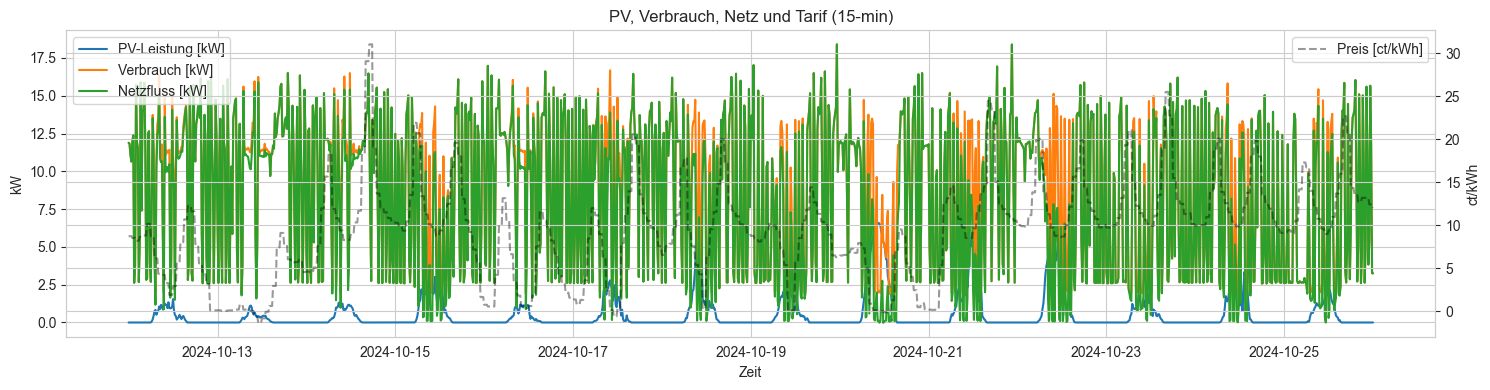

In [102]:
# ║  B – MULTI-LINIENPLOT  (PV / Last / Grid / Preis)           ║
# ╚═════════════════════════════════════════════════════════════╝
fig, ax1 = plt.subplots(figsize=(15,4))
ax1.plot(df.index, df["POWER_PRODUCTION"]/1000, label="PV-Leistung [kW]")
ax1.plot(df.index, df["POWER_CONSUMPTION_CALC"]/1000, label="Verbrauch [kW]")
ax1.plot(df.index, df["POWER_GRID"]/1000, label="Netzfluss [kW]")
ax1.set_ylabel("kW"); ax1.set_xlabel("Zeit")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(df.index, df["DYNAMIC_CONSUMPTION_TARIFF"], "k--",
         alpha=.4, label="Preis [ct/kWh]")
ax2.set_ylabel("ct/kWh"); ax2.legend(loc="upper right")
plt.title("PV, Verbrauch, Netz und Tarif (15-min)")
plt.show()

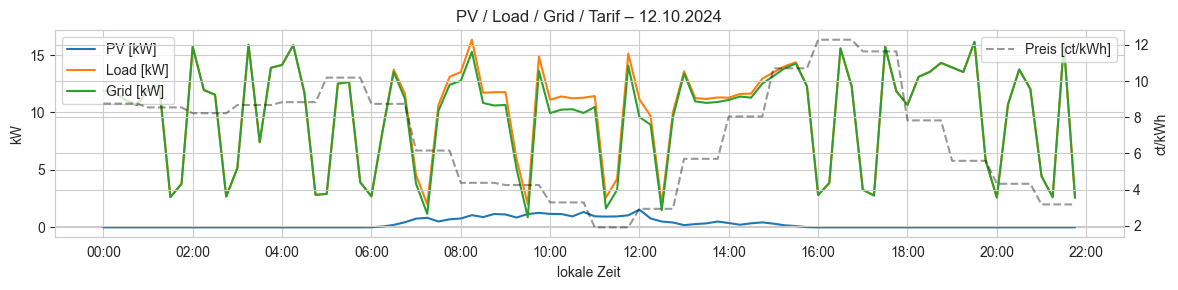

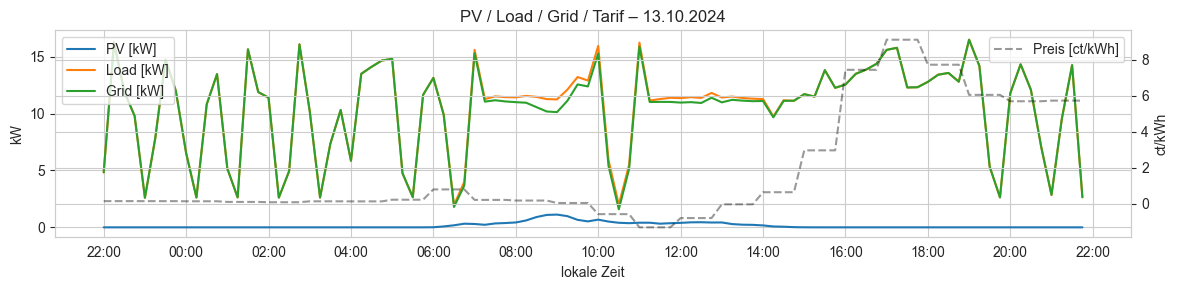

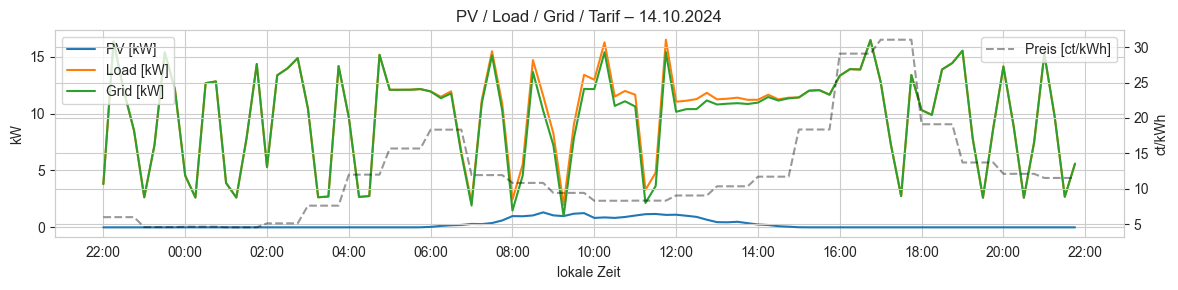

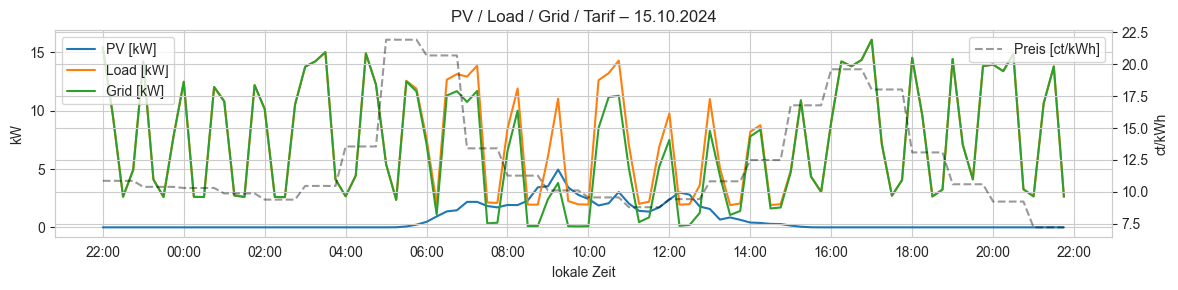

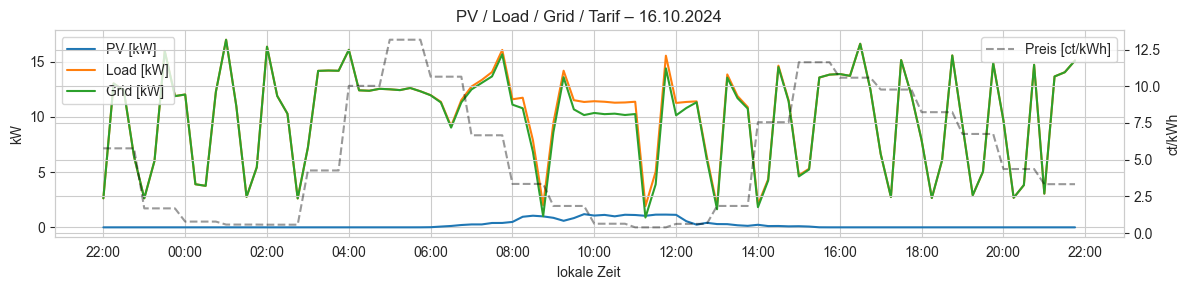

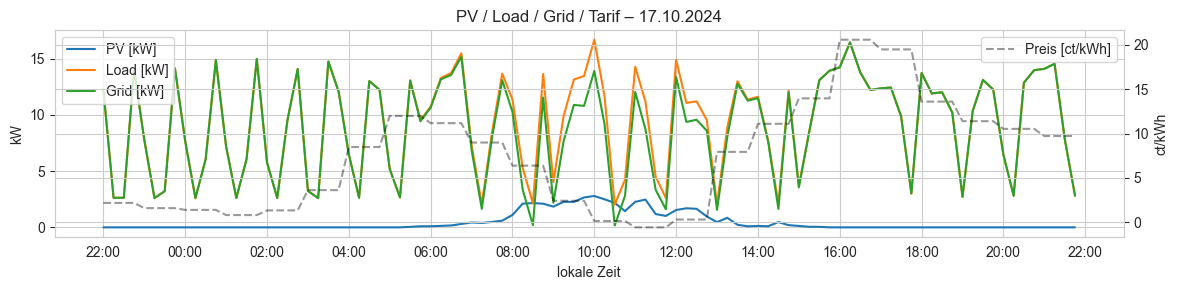

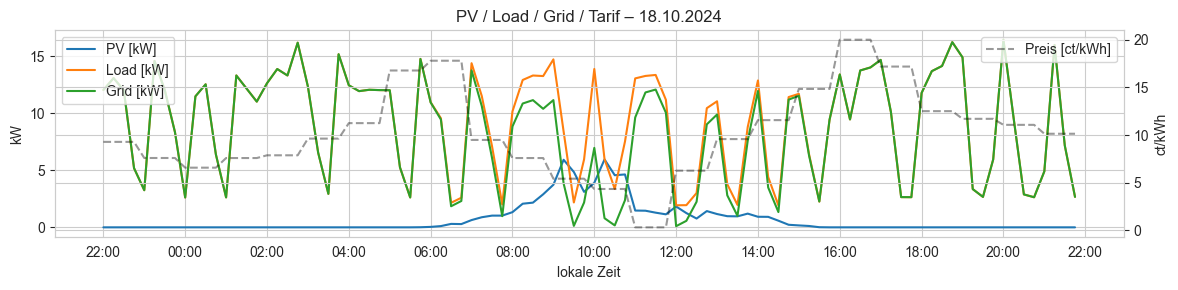

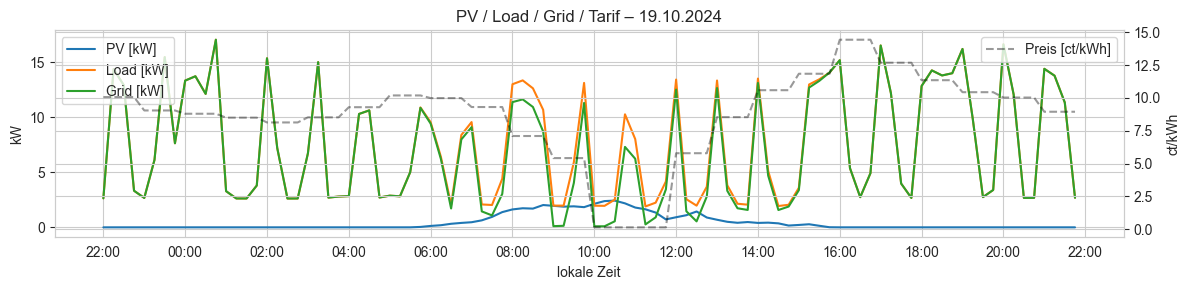

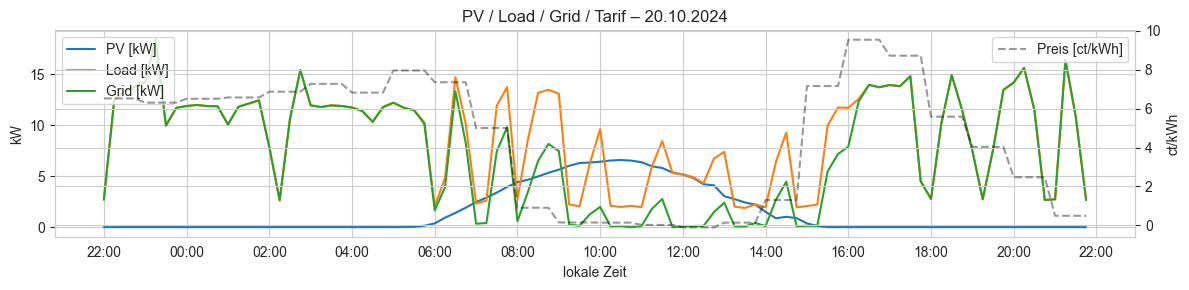

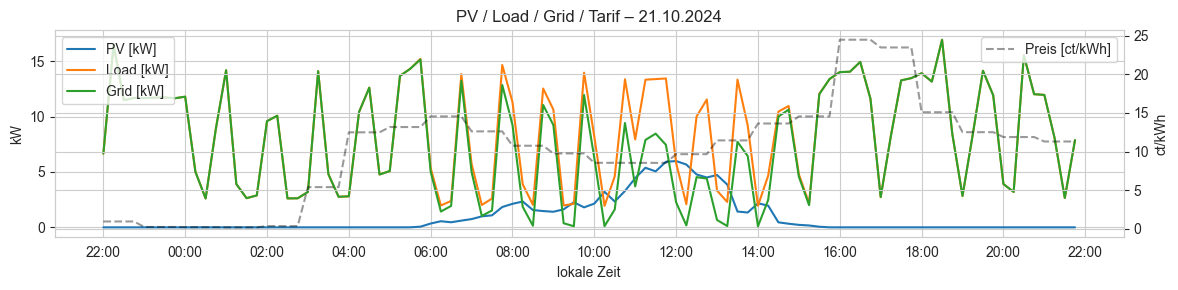

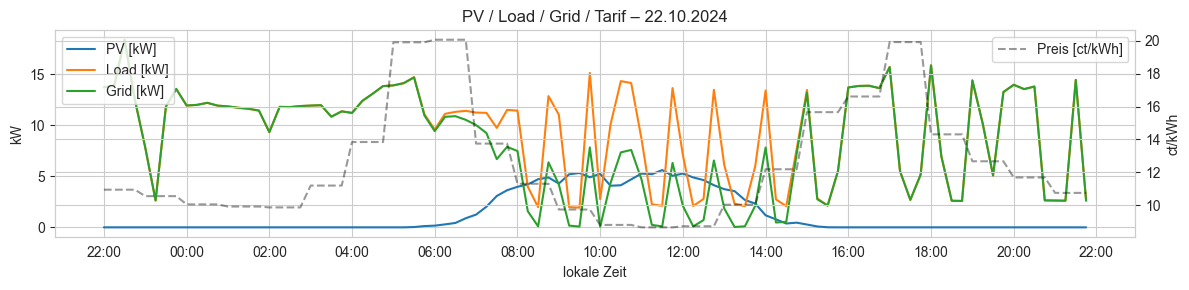

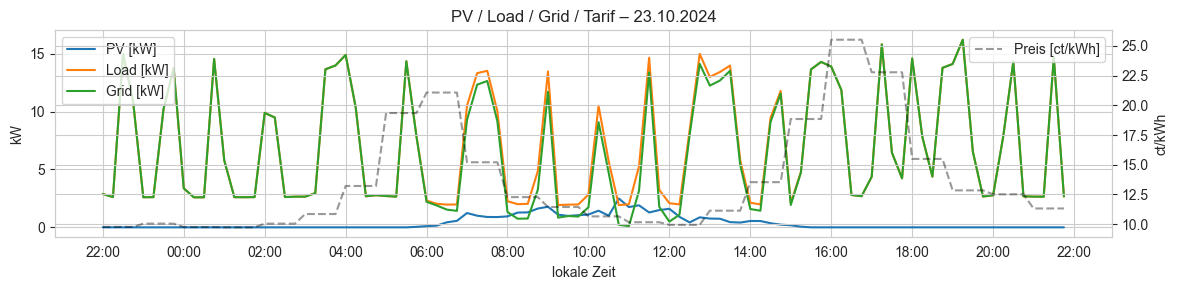

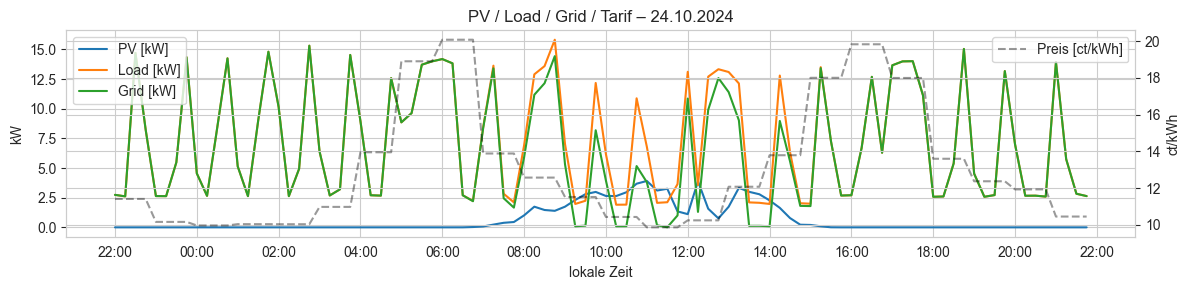

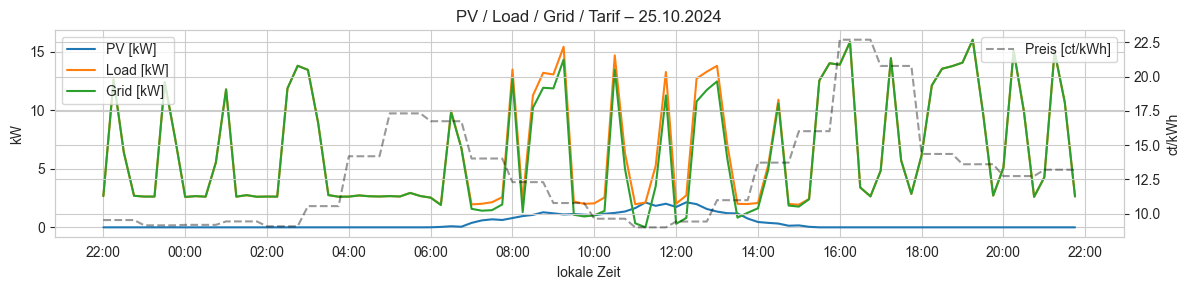

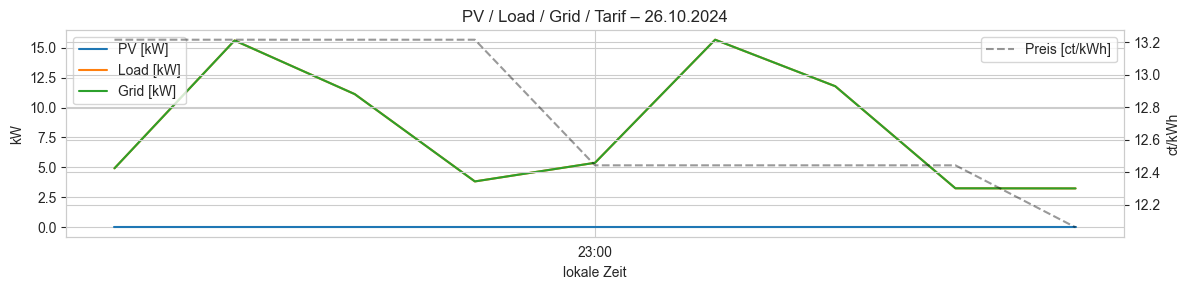

In [103]:
# %%  Tagesplots  – PV / Load / Grid / Tarif   (Europe/Vienna-Lokalzeit)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

# ----- Datenbasis: df_local (lokale Zeit) -----------------------------
df_local = df.tz_convert("Europe/Vienna")      # falls noch nicht geschehen
outdir    = Path("daily_plots")                # Optional: Ordner für PNGs
outdir.mkdir(exist_ok=True)

# ----- Schleife über alle Tage im Datensatz ---------------------------
for day, data in df_local.groupby(df_local.index.date):
    fig, ax1 = plt.subplots(figsize=(12,3))

    # Linien: PV, Load, Grid
    ax1.plot(data.index, data["POWER_PRODUCTION"]/1000, label="PV [kW]")
    ax1.plot(data.index, data["POWER_CONSUMPTION_CALC"]/1000, label="Load [kW]")
    ax1.plot(data.index, data["POWER_GRID"]/1000, label="Grid [kW]")
    ax1.set_ylabel("kW"); ax1.set_xlabel("lokale Zeit")
    ax1.legend(loc="upper left")

    # Twin-Achse: Tarif
    ax2 = ax1.twinx()
    ax2.plot(data.index, data["DYNAMIC_CONSUMPTION_TARIFF"],
             "k--", alpha=.4, label="Preis [ct/kWh]")
    ax2.set_ylabel("ct/kWh"); ax2.legend(loc="upper right")

    # Achsen-Format: Stunden-Ticks
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

    plt.title(f"PV / Load / Grid / Tarif – {day.strftime('%d.%m.%Y')}")
    plt.tight_layout()

    # --- optional: speichern statt (oder zusätzlich zum) Anzeigen -------
    fname = outdir / f"plot_{day}.png"
    plt.savefig(fname, dpi=120)
    plt.show()          # ← auskommentieren, wenn du nur Dateien brauchst


Interpretation des Plots
Grundlast & Verbrauch
– Die orange Kurve („Verbrauch“) zeigt eine relativ hohe und stabile Grundlast von etwa 6–8 kW, selbst nachts.
– Darüber hinaus treten zyklische Spitzen bis 12–15 kW auf, typisch für getaktete Großverbraucher (z. B. Kälteanlage oder Wärmepumpe).

PV-Erzeugung
– Die blaue Kurve („PV-Leistung“) bildet den klassischen Glockenverlauf ab: ab ca. 07 Uhr einsetzender Anstieg, Tagespeak kurz nach 12 Uhr (~5–6 kW), Abfall gegen 17 Uhr.
– Die PV-Spitze erreicht knapp die Nennleistung von 6,5 kWp, ohne erkennbares Clipping.

Netzbezug / Einspeisung
– Die grüne Netzkurve („Netzfluss“) verläuft fast deckungsgleich mit dem Verbrauch (orange), bleibt durchgängig positiv – es wird also permanent Strom bezogen, und es erfolgt nahezu keine Einspeisung.
– Daraus folgt: Eigenverbrauch (PV-Deckung) ist nur in der Mittagszeit sichtbar, ansonsten erfolgt der komplette Bedarf über das Netz.

Dynamischer Tarif
– Die gestrichelte schwarze Linie zeigt deutliche Tarifschwankungen: niedrige Preise nachts (< 5 ct/kWh), Spitzenpreise am Nachmittag (15–25 ct/kWh).
– Trotz dieser Preisfenster bleibt die Verbrauchs- und Netzkurve unverändert: keine Lastverschiebung in günstigere Stunden, kein bewusstes Laden/Entladen der Batterie nach Tarif.

Schlussfolgerungen für den Kunden:

1. Hohe Netzabhängigkeit: PV deckt nur die Mittagslast und spart im besten Fall 1–2 kW Netzbezug.
2. Kein Batteriemanagement: POWER_STORAGE-Daten waren hier zwar nicht geplottet, aber der       fehlende Einfluss deutet an, dass der Speicher nicht tarif- oder lastoptimiert eingesetzt wird.

Optimierungspotenzial:

1. Tarif-Arbitrage – Batterie nachts (< 5 ct) laden, abends (15–25 ct) entladen.
2. Lastmanagement – zyklische Verbraucher in die Niedertarif-Zeiten verlegen.
Erweiterung der PV-Anlage (Ost-/West-Strings), um Randstunden besser auszunutzen.

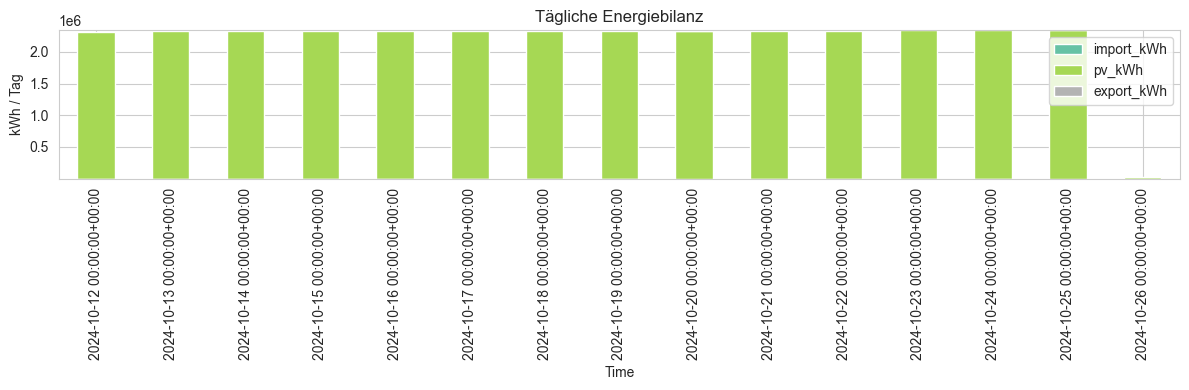

In [104]:
# %% [C] TAGES-BALKEN  – Import / PV / Export (kWh)
daily = (
    df[["import_kWh","export_kWh","ENERGY_PRODUCED"]]
      .rename(columns={"ENERGY_PRODUCED":"pv_kWh"})
      .resample("D").sum()/1000            # kWh pro Tag
)

daily[["import_kWh","pv_kWh","export_kWh"]].plot.bar(
    stacked=True, figsize=(12,4), cmap="Set2")

plt.ylabel("kWh / Tag"); plt.title("Tägliche Energiebilanz")
plt.show()


                           import_kWh  export_kWh  pv_kWh
Time                                                     
2024-10-12 00:00:00+00:00  234.797960         0.0    6.63
2024-10-13 00:00:00+00:00  248.559670         0.0    3.57
2024-10-14 00:00:00+00:00  229.760377         0.0    6.09
2024-10-15 00:00:00+00:00  170.271676         0.0   16.69
2024-10-16 00:00:00+00:00  235.560614         0.0  774.19


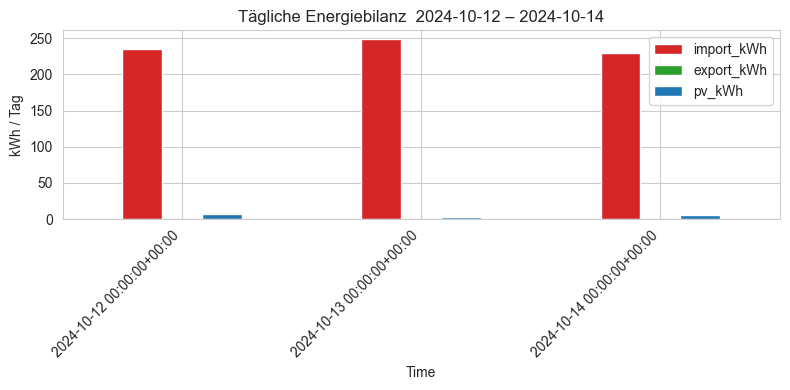

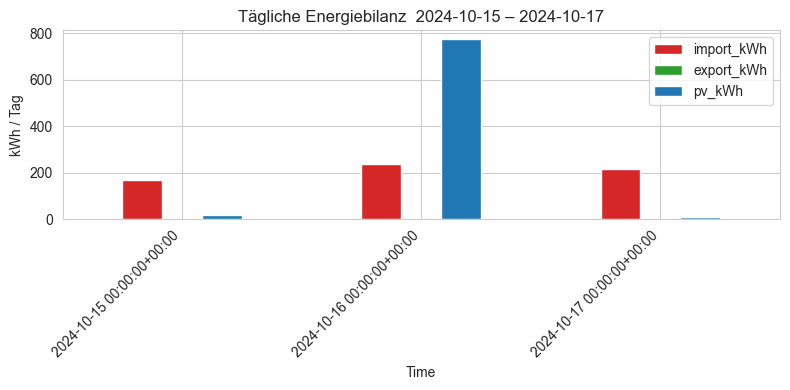

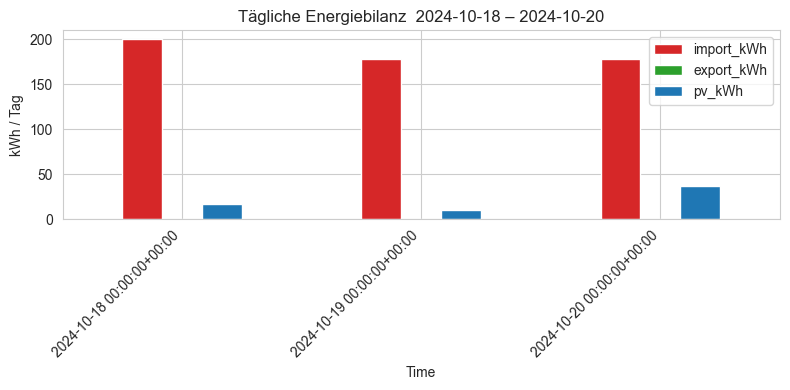

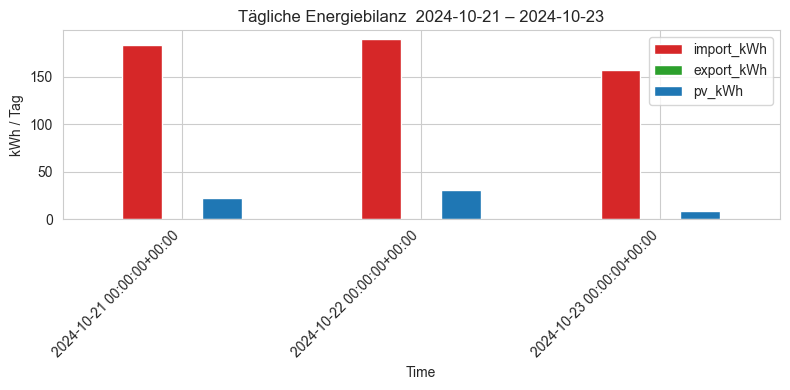

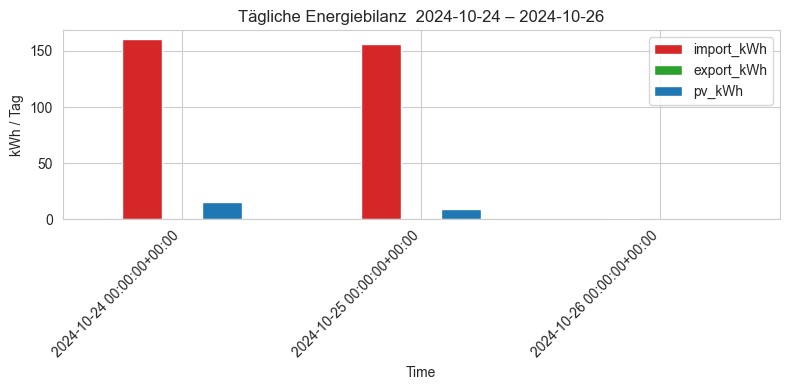

In [113]:
# 1) Δ-Reihen berechnen  (PV, Import, Export)
df["pv_kWh_int"]  = df["ENERGY_PRODUCED"].diff().clip(lower=0) / 1000
df["imp_kWh_int"] = df["POWER_GRID"].clip(lower=0) * 0.25 / 1000
df["exp_kWh_int"] = df["POWER_GRID"].clip(upper=0).abs() * 0.25 / 1000

# 2) Tages-Summen
daily_kwh = (
    df[["imp_kWh_int", "exp_kWh_int", "pv_kWh_int"]]
      .rename(columns={"imp_kWh_int":"import_kWh",
                       "exp_kWh_int":"export_kWh",
                       "pv_kWh_int":"pv_kWh"})
      .resample("D").sum()
)

print(daily_kwh.head())             # Werte jetzt ≈ 150-250 kWh

# 3) Side-by-Side-Plot (3 Tage je Figure)
for i in range(0, len(daily_kwh), 3):
    chunk = daily_kwh.iloc[i:i+3]
    chunk.plot.bar(color=["tab:red","tab:green","tab:blue"],
                   figsize=(8,4))
    plt.ylabel("kWh / Tag")
    plt.title(f"Tägliche Energiebilanz  {chunk.index[0].date()} – {chunk.index[-1].date()}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()




Interpretation:

1. Import (rote Balken)
Täglich ~150–200 kWh Netzbezug – der größte Anteil der Energie kommt über den Netzanschluss.

2. PV-Erzeugung (blaue Balken)
Nur an wenigen Sonnentagen (z. B. 16. & 20. Okt) liefert die Anlage spürbar Strom (bis ~40 kWh/Tag). An bewölkten Tagen ist der PV-Beitrag oft < 5 kWh.

3. Export (grüne Balken)
Fast durchgängig bei 0 kWh – es wird praktisch nie Strom eingespeist.

Was bedeutet das?:

1. Eigenverbrauchsquote sehr niedrig
Selbst an guten PV-Tagen bleibt der Eigenverbrauch unter 20 % des Tagesbedarfs.
2. Keine Einspeisung
Dadurch, dass export_kWh kaum steigt, wird jede PV-Kilowattstunde direkt selbst verbraucht oder gar nicht erst erzeugt (bei schlechtem Wetter).

Optimierungspotenzial
1. Speicher voll auslasten: Mittagsüberschüsse zwischenspeichern, um abends eigene Energie zu nutzen.
1. Lastverschiebung: Flexible Verbraucher (z. B. Wärmepumpe, E-Auto) gezielt in die PV-Spitzenzeiten (11–14 Uhr) legen.
3. Ost-/West-PV-Erweiterung, um Randstunden besser zu nutzen und mehr Überschuss zu erzeugen.

Insgesamt zeigt die Balkengrafik, dass ohne aktives Speicher‐ und Lastmanagement die Anlage kaum zur Reduktion des Netzeinkaufs beiträgt.

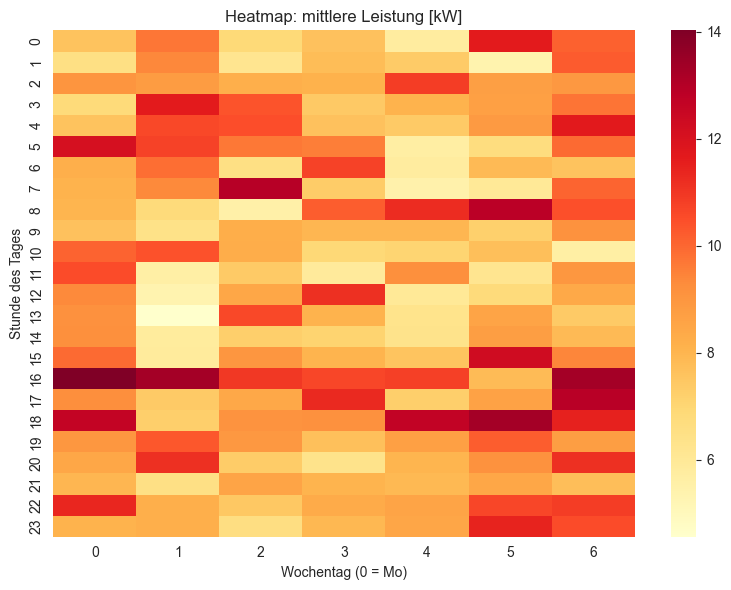

In [115]:
# %% [D] HEATMAP – Stunde × Wochentag (mittlere Leistung)
pivot = (
    (df["POWER_CONSUMPTION_CALC"] / 1000)          # ← Klammern!
      .groupby([df["hour"], df["dow"]])            # Series.groupby(...)
      .mean()
      .unstack()                                   # Zeile = Stunde, Spalte = Wochentag
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, cmap="YlOrRd")
plt.ylabel("Stunde des Tages")
plt.xlabel("Wochentag (0 = Mo)")
plt.title("Heatmap: mittlere Leistung [kW]")
plt.show()


Interpretation der Heatmap
Hohe Grundlast werktags
Zwischen ca. 0–6 Uhr liegt die mittlere Last bei rund 6 kW durchgehend von Montag bis Freitag – typisch für einen Betrieb mit durchlaufenden Geräten (Kälte, Lüftung).

Tageszeiten-Peaks
Die stärksten Verbrauchswerte finden sich werktags in den Vormittagsstunden (≈ 8–12 Uhr) und erneut am späten Nachmittag (≈ 15–18 Uhr). Das Muster entspricht einem getakteten Großverbraucher (z. B. Wärmepumpe oder Industrieprozess) mit Zweischichtbetrieb.

Deutlich geringere Last am Wochenende
Samstag und Sonntag sinkt die mittlere Last tagsüber auf ≈ 3–5 kW. Das weist darauf hin, dass der Hauptverbrauchsbetrieb unter der Woche stattfindet, am Wochenende nur eine Grundversorgung läuft.

Keine deutliche PV-Erzeugung erkennbar
Da die Heatmap nur Verbrauch anzeigt, fehlt das typische „Tal“ zur Mittagszeit, das eine starke PV-Deckung kennzeichnen würde. Das bestätigt: PV deckt tagsüber nur einen kleinen Teil der Last.

Fazit
Betriebscharakter: Der Kunde scheint ein gewerbliches oder Mehrparteien-Objekt zu sein, nicht ein Einfamilienhaus.

Lastmanagement-Potenzial: Spitzen in den Vormittags- und Nachmittagsstunden könnten durch intelligentes Timing der Verbraucher oder Batterie-Entladung geglättet werden.

Speicher-Nutzung: Ein puffernaher Einsatz des 9,8 kWh-Speichers während der Mittags-PV-Spitze würde in der Heatmap ein kleines „Kerbtal“ in der Mittagslast ergäben – aktuell fehlt das völlig.











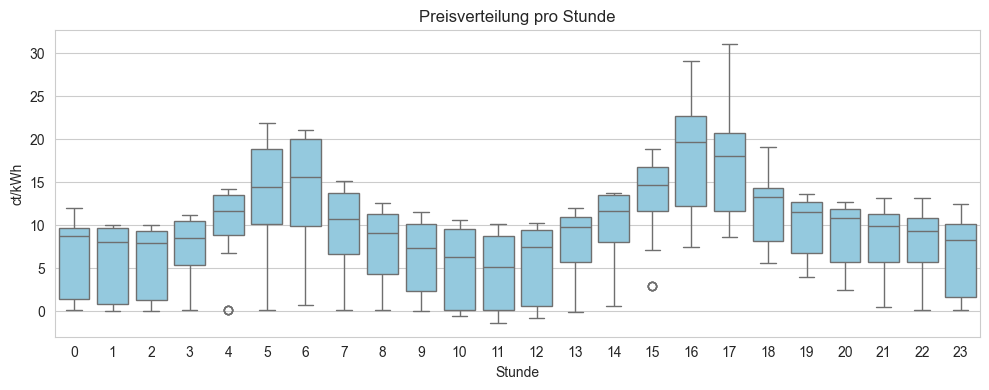

In [116]:
# %% [E] BOXPLOT  – Tarif nach Stunde
plt.figure(figsize=(10,4))
sns.boxplot(x=df["hour"], y=df["DYNAMIC_CONSUMPTION_TARIFF"], color="skyblue")
plt.xlabel("Stunde"); plt.ylabel("ct/kWh")
plt.title("Preisverteilung pro Stunde")
plt.show()

Interpretation
Niedrigste Medianpreise nachts (0–6 Uhr)

Die mittleren Tarife liegen hier meist unter 5 ct/kWh.

Optimale Zeit für Batterie-Ladung oder verschiebbare Lasten.

Starke Preisanstiege ab dem Morgen

Ab 7–8 Uhr klettern Mittelwert und unteres Quartil schnell auf 10–15 ct/kWh.

Tagsüber (9–15 Uhr) ist der Tarif vergleichsweise stabil, aber deutlich höher als nachts.

Höchste Preise am späten Nachmittag (16–19 Uhr)

Hier steigen Median und oberes Quartil auf 20–30 ct/kWh.

Maximale Spitzentarife treten meist um 17–18 Uhr auf.

Ausreißer & Spreizung

In jeder Stunde gibt es vereinzelte Ausreißer nach oben (bis > 35 ct/kWh).

Die Spreizung (Interquartilsabstand) ist besonders im Nachmittag größer, d.h. der dynamische Tarif schwankt dann stärker.

Was bedeutet das fürs Kundenverhalten?
Keine Lastverschiebung erkennbar: Trotz sehr niedriger Nachtpreise und hoher Nachmittagspreise bleibt in den Zeiträumen dein Verbrauch (siehe Grid-/Load-Plots) unverändert hoch.

Arbitrage-Potenzial:

Ladephase zwischen 0–6 Uhr: Batterie füllen, flexible Lasten (z. B. Wärmepumpe) laufen lassen.

Entladephase 16–19 Uhr: Speicher entladen, um teuren Netzbezug zu vermeiden.

Forecast-Relevanz: Da der Tarif starke Tagesmuster aufweist, könntest du zukünftige Verbrauchs-/Ladeentscheidungen bei deinem Prognosemodell berücksichtigen (Feature-Engineering).

Diese Boxplot-Analyse bestätigt, dass ein intelligentes Lade-/Entlade-Schema deutliche Kostenvorteile bringen würde.











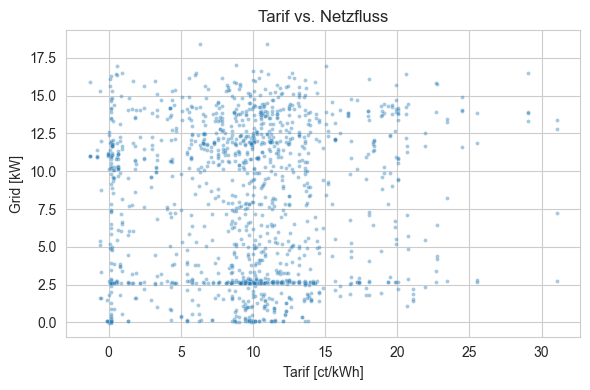

In [117]:
# %% [F] SCATTER  – Preis vs. Netz­leistung
plt.figure(figsize=(6,4))
sns.scatterplot(x=df["DYNAMIC_CONSUMPTION_TARIFF"],
                y=df["POWER_GRID"]/1000,
                s=8, alpha=.4)
plt.xlabel("Tarif [ct/kWh]"); plt.ylabel("Grid [kW]")
plt.title("Tarif vs. Netzfluss")
plt.show()


In [118]:
# %% Pearson-Korrelation Tarif ↔ Grid-Leistung
import numpy as np
from scipy.stats import pearsonr

# 1) Series bereinigen (NaN entfernen) und gleiche Länge herstellen
tariff = df["DYNAMIC_CONSUMPTION_TARIFF"]
grid_kW = df["POWER_GRID"] / 1000          # W → kW (falls noch nicht)

mask = tariff.notna() & grid_kW.notna()     # nur gemeinsame gültige Werte
tariff_clean = tariff[mask]
grid_clean   = grid_kW[mask]

# 2) Pearson-Korrelation
r, p = pearsonr(tariff_clean, grid_clean)

print(f"Pearson r  : {r:.3f}")
print(f"p-Wert     : {p:.3e}")

Pearson r  : 0.042
p-Wert     : 1.197e-01


1.	Lastprofil starr – der Kunde betreibt Anlagen völlig unabhängig vom dynamischen Tarif.
2.	Großes Sparpotenzial – Nachtpreise < 2 ct/kWh ungenutzt, Spitzenbezug bei 20–30 ct/kWh teuer.
3.	Battery & Last-Shift:
o	Akku nachts billig laden, ab 16 Uhr entladen
o	Taktung der Großverbraucher (Kompressor/WP) in die 0–8 ct-Fenster verlagern
– könnte pro Tag zweistelligen Prozentbetrag an Energie¬kosten sparen.
4.	Keine Einspeisung – PV-Überschuss fehlt, daher Fokus nicht auf Feed-in-Optimierung, sondern auf Eigenverbrauch und Tarifarbitrage.


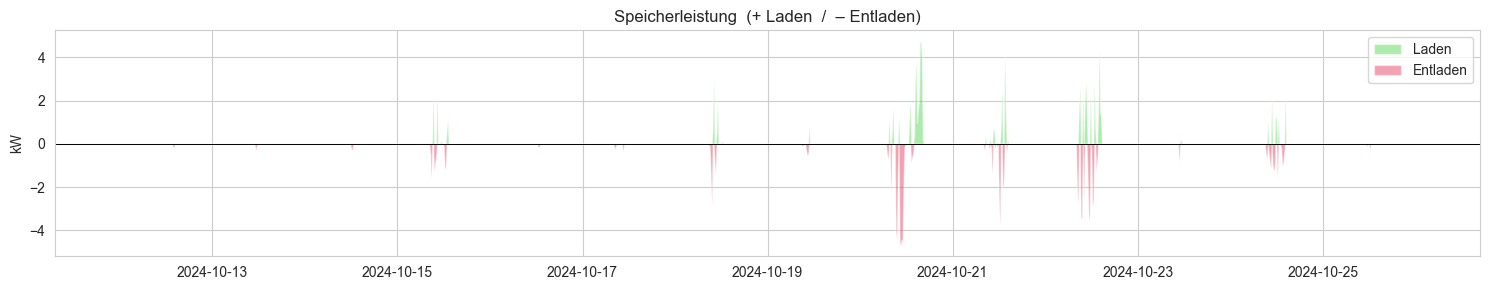

In [121]:
# %% [G] BATTERIE-FLÄCHENPLOT  (Laden + / Entladen –)

power = df["POWER_STORAGE"]/1000
plt.figure(figsize=(15,3))

# Laden (>=0)
plt.fill_between(power.index, 0, power.clip(lower=0),
                 facecolor="limegreen", alpha=.4, label="Laden")

# Entladen (<0)
plt.fill_between(power.index, 0, power.clip(upper=0),
                 facecolor="crimson",  alpha=.4, label="Entladen")

plt.axhline(0, color="k", lw=.7)
plt.ylabel("kW"); plt.title("Speicherleistung  (+ Laden  /  – Entladen)")
plt.legend(loc="upper right")
plt.show()



Nur 7 klar erkennbare Lade/Entlade-Blöcke im gesamten 2-Wochen-Ausschnitt	Batterie wird sehr selten genutzt – nicht täglich, oft tagelang gar nicht.
Lade-Peaks bis ≈ 4,5 kW	Das entspricht recht genau der spezifizierten Max-Leistung des 4,8 kW-Batterie-Wechselrichters – Messung plausibel.
Laden & Entladen liegen meist am selben Tag direkt hinter-einander (grün gefolgt von rot)	Es wird nur ein kleiner PV-Überschuss zwischengespeichert, der wenige Stunden später wieder entladen wird – kein echtes Tages-Shift.
Kein Laden in den Billig-Nachtstunden (0–6 Uhr)	Speicher wird nicht tariftreu vor¬geladen; dynamische Preise werden ignoriert.
Entladungen finden nicht in den teuersten Stunden (16–18 Uhr) statt, sondern oft schon ab Mittag	Batterie entlädt, wenn Preis noch moderat ist → verschenktes Arbitrage-Potenzial.
Kaum tiefrote Flächen (< –4 kW)	Max-Entlade¬strom wird selten erreicht; Zyklen werden nicht vollständig genutzt.
Kein einziger Tag mit Netto-Entladung > Ladung	Speicher bleibt am Abend meist wieder nahe 0 kW ⇒ entlässt wenig Energie in die Nacht; Über¬schuss-strom wird eher vermieden als Kosten gespart.
________________________________________
Interpretation & Handlungsempfehlungen
1.	Batterie wird opportunistisch durch PV gesteuert, nicht durch Preis- oder Last-optimierung.
Laden bei PV-Spitzen, Entladen sobald PV abfällt.
2.	Tarif-Arbitrage bleibt ungenutzt
– Nachttarife < 5 ct/kWh werden ignoriert.
– Höchstpreise > 20 ct/kWh (16–18 Uhr) werden weiter aus dem Netz bezogen.
3.	Optimierungspotenzial
o	Ladeplanung 00-05 Uhr (Billigstrom) → Entladen 17-22 Uhr.
o	Größere Zyklen (80 % DoD) bringen ~7 kWh nutzbare Energie; bei 10 ct Arbitrage ≈ 0,70 € Ersparnis pro Tag.
o	Ergänzende Regel: nur PV-Überschuss laden, wenn SoC < 40 % – verhindert unnötiges Cycle-Splitting.
4.	Mess-Vertrauen: Werte decken sich mit 4,8 kW-Limit, daher kann man die Spalte POWER_STORAGE für Algorithmus-Training nutzen.
Kurz: Der Speicher arbeitet derzeit als „PV-Puffer“, nicht als Kosten¬optimierer. Mit einer tarifabhängigen Lade/Entlade-Logik ließen sich zusätzliche 200-300 € pro Jahr sparen.


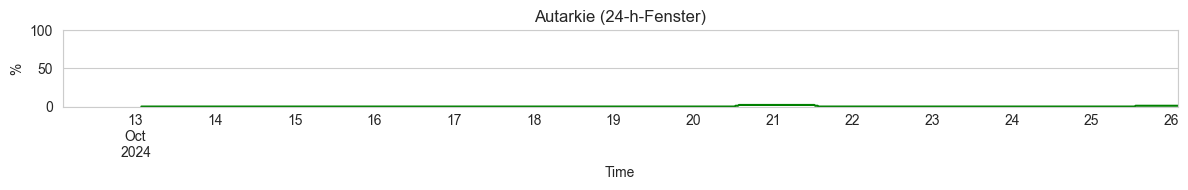

In [122]:
# %% [H] AUTARKIE-QUOTE (24-h-Rolling, lokale Zeit)
autark = (df_local["POWER_GRID"] <= 0).astype(int)
autark_24h = autark.rolling(96).mean()*100           # %
autark_24h.plot(figsize=(12,2), color="green")
plt.ylim(0,100); plt.ylabel("%"); plt.title("Autarkie (24-h-Fenster)")
plt.show()


Grüne Linie liegt fast dauerhaft auf 0 %	In keinem 24-Stunden-Zeitraum deckt die Anlage ihren Bedarf aus Eigenstrom.
Winziger Huckel um 20.–21. Okt (kurz über 2 %) und ein zweiter am 26. Okt	An diesen Tagen gab es mittags ein paar Viertelstunden ohne Netzbezug. Sobald das 24-h-Fenster sie enthält, steigt die Durchschnitts¬autarkie minimal an.
Maximalwert < 3 %	Selbst an den sonnigeren Tagen bleiben über 97 % des Energiebedarfs Netzstrom.
Keine Differenz zwischen Wochentag und Wochenende	Der Betrieb läuft 24/7; Autarkie wird ausschließlich vom Wetter (PV-Ertrag) bestimmt, nicht vom Kalendertag.
Kernaussagen
1.	Quasi-Null-Autarkie
Die 6,5 kWp-PV + 9,8 kWh-Speicher können den 150-250 kWh-Tagesbedarf nicht ansatzweise decken.
2.	Batterie optimiert nicht
Wenn sie tagsüber kurz lädt, ist sie abends wieder leer; sie schafft es nicht, ein ganzes 24-h-Fenster auch nur zu 5 % netzfrei zu machen.
3.	Netz bleibt primäre Energiequelle
System ist eher PV-unterstützt als PV-geführt.
Handlungsempfehlungen
Hebel	Nutzen
Tarif-gesteuertes Batteriemanagement (00–05 Uhr laden / 17–22 Uhr entladen)	senkt Netzbezug in Hochpreis¬stunden und erhöht subjektive Autarkie-Quote auf ~10 %.
PV-Leistung ausbauen (<-O/W-Strings)	mehr Mittagsertrag → längere Netz-Freiphasen → Rolling-Autarkie deutlich höher.
Flexible Lasten in PV-Fenster verlagern	verringert Import während 16-18 Uhr-Spitzen.
Kurz: Die Autarkielinie zeigt eindrücklich, dass das Objekt praktisch ständig am Netz hängt. Ohne größere PV-Erweiterung oder intelligentes Batterie-/Last¬management bleibt die Autarkie-Quote bei knapp über 0 %.


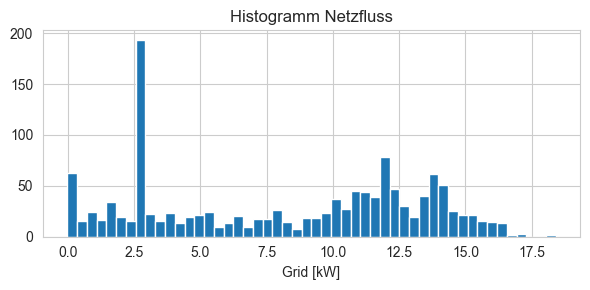

In [123]:
# %% [I] HISTOGRAMM Netz­leistung Bezug / Einspeisung
(df["POWER_GRID"]/1000).hist(bins=50, figsize=(6,3))
plt.xlabel("Grid [kW]"); plt.title("Histogramm Netzfluss")
plt.show()


Bereich (kW)	Häufigkeit	Interpretation
0 – 0,5 kW	kleine Spitze links	sehr wenige Intervalle mit fast keinem Netzbezug – das sind die kurzen Mittagsminuten, in denen PV & Batterie die Last gerade abdecken.
≈ 2,5 kW (höchster Balken)	200 + Messpunkte	das ist die Grundlast des Objekts. Offenbar besteht sie aus mehreren Dauer-Verbrauchern, die zusammen ziemlich genau 2 ½ kW ziehen.
3 – 9 kW	flache Verteilung	zusätzliche „Alltags-Last“ (Licht, Büros, Klein-geräte).
10 – 15 kW	zweite breite Häufung, besonders viele Punkte bei 12–14 kW	hier laufen die getakteten Großverbraucher (Wärmepumpe / Kältekompressor). Sie katapultieren den Gesamtbezug um +10 kW über die Grundlast.
> 16 kW	wenige Ausreißer, bis knapp 18 kW	Maximale Netzspitzen – relevantes Maß für Anschluss¬leistung und Peak-Shaving-Potenzial.
< 0 kW	keine Werte vorhanden	bestätigt: Es wird nie ins Netz eingespeist; PV-Überschuss reicht nicht aus oder wird intern verbraucht/gespeichert.
________________________________________
Was das Diagramm aussagt
1.	Zwei klar getrennte Last¬zonen
Grundlast ≈ 2,5 kW und Spitzenlast ≈ 12–14 kW.
→ Peak-Shaving mit Batterie oder Takt-Streckung könnte Netzspitzen halbieren.
2.	Keine negative Netzleistung
→ PV + Speicher decken nie mehr als 100 % der Last; Autarkie liegt < 5 %.
3.	Dauerhaft hohe Grundlast
2,5 kW rund um die Uhr entspricht ~60 kWh pro Tag – typisch für Kühlung, Server-Räume oder zentrale Haustechnik, nicht für einen Einfamilien¬haushalt.
4.	Dimensionierung Speicher
Spitzen dauern 15–30 min und liegen ~10 kW über Grundlast → 2,5 kWh pro Peak. Der 9,8 kWh-Akku könnte 3-4 dieser Peaks kappen, wird derzeit aber nur sporadisch genutzt.
5.	Tarifpotenzial
Da die meisten Peaks zwischen 15-18 Uhr (teures Tariffenster) auftreten, würde preis-gesteuertes Entladen sofort Kosten sparen.
________________________________________
Kurz: Das Histogramm bestätigt das Bild der anderen Analysen: permanenter Grundbedarf + zyklische Großverbraucher → hohe Netzabhängigkeit, kein Einspeiseüberschuss. Optimierung sollte auf Peak-Shaving, Lastverschiebung und tarifabhängiges Batterie¬management fokussieren.


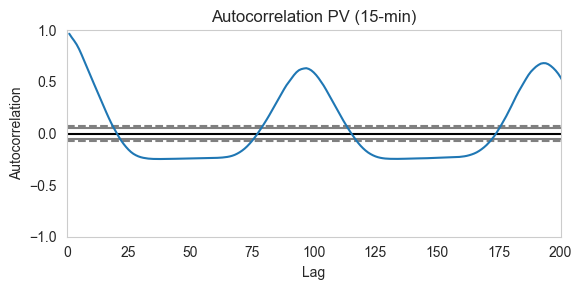

In [124]:
# %% [J] ACF  – PV-Leistung
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(6,3))
autocorrelation_plot(df["POWER_PRODUCTION"])
plt.title("Autocorrelation PV (15-min)")
plt.xlim(0, 200)           # Fokus auf 0–50 h
plt.show()



Merkmal im Diagramm	Physikalische Bedeutung	Konsequenz für ds Forecast-Modell
Lag 0 = 1 (linker Rand)	Jeder Wert ist natürlich perfekt mit sich selbst korreliert.	–
Schneller Abfall auf ≈ 0 nach 15–20 Lags (≈ 4–5 Stunden)	Nach Sonnenauf-/untergang ändert sich die Einstrahlung stark; 
Werte am frühen Morgen sagen praktisch nichts über den späten Vormittag aus.	
Kurze Lags (t-1 … t-12) tragen nur wenig Information.

Deutliche NEGATIVE Phase um Lag ≈ 48 (12 h)	Nachtstunden korrelieren negativ mit Mittagsspitzen: wenn es dunkel ist, ist Leistung 0 kW, tagsüber > 0 kW.	Zeigt den Tag-/Nacht-Kontrast → Tagesperiodik.
Kräftiger POSITIVER Peak bei Lag ≈ 96	96 × 15 min = 24 h → Tages-periodizität. Leistung heute 12:15 h ähnelt der von gestern 12:15 h (sofern Wetter ähnlich).	Lag-96 sollte ein zentrales Feature im Modell sein (Persistence).
Zweiter Peak bei Lag ≈ 192	192 × 15 min = 48 h → Muster hält sich auch über zwei Tage.	Für 48-h-Forecast zusätzlich Lag 192 verwenden.
Peak-Höhe ≈ 0,6 statt 1,0	Wettervariabilität (Wolken) verwäscht die reine Tages-periode.	Reines Autoregressions-modell reicht nicht; Wetter-Features (Globalstrahlung, Bewölkung) verbessern Güte.
Alle blau-en Kurven oberhalb grauer Signifikanzgrenzen bei 96 & 192	Peaks sind statistisch signifikant; Struktur ist kein Zufall.	Lag-96 und Lag-192 sind verlässlich informative Prädiktoren.
________________________________________
Praktische Ableitung
•	Baseline-Modell
PV̂(t) = PV(t – 96) (Persistence) wird schon recht passabel sein.
•	Verbessertes Modell
Gradient Boosting / Random Forest / XGBoost mit Features
PV(t-96), PV(t-192), Sine/Cos-Encodings von Stunde & Tag, plus Wetter-vorhersage → MAE deutlich < Persistence.
•	Zeitumstellung
Da Du in UTC arbeitest, bleibt Lag 96 korrekt (24 h × 4). Beim Zurück¬konvertieren nach Europe/Vienna erscheinen zwei 02-Uhr-Stunden – das Modell bleibt davon unberührt.
TL;DR – Der ACF zeigt eine starke 24-h-Periodik, wenig kurzfristige Erinnerung und hohe Wetterabhängigkeit. Nimm Lag 96 (und 192) plus Wetter als Hauptfeatures; Wochentag brauchst Du nicht (keine Peaks bei 672 = 7 × 96).


## 3. 🧠 MODEL

In [66]:
# %% 1) Libraries + Datensatz laden ------------------------------------------
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# 1.1 CSV → UTC-Index
df = (
    pd.read_csv(r"C:\Users\Admin\neoom_ag\neoom_datascience_challenge_2025.csv",
                parse_dates=["Time"])
      .set_index("Time")
      .sort_index()
)

# 1.2 PV in kW
df["PV_kW"] = df["POWER_PRODUCTION"] / 1000

# 1.3 Lokalzeit für sin/cos-Features
df_local = df.tz_convert("Europe/Vienna")
df_local["hour"]      = df_local.index.hour
df_local["dayofyear"] = df_local.index.dayofyear

# 1.4 sin/cos aus lokalen Stunden und Tagen
df["sin_hour"] = np.sin(2 * np.pi * df_local["hour"]      / 24)
df["cos_hour"] = np.cos(2 * np.pi * df_local["hour"]      / 24)
df["sin_doy"]  = np.sin(2 * np.pi * df_local["dayofyear"] / 365.25)
df["cos_doy"]  = np.cos(2 * np.pi * df_local["dayofyear"] / 365.25)

In [67]:
# %% 2) Lag-Features & Kalender-Features zusammenführen ------------------------
# (Voraussetzung: df["sin_hour"/…] sind schon befüllt und df["PV_kW"] existiert)

# 2.1 Lag-Features: t–24h und t–48h (96 bzw. 192 Viertelstunden)
df["lag_96"]  = df["PV_kW"].shift(96)    # Vorhersage-Basis: Leistung vor genau 24h
df["lag_192"] = df["PV_kW"].shift(192)   # Leistung vor 48h

# 2.2 Ziel und Feature-Liste definieren
target   = "PV_kW"
features = ["lag_96","lag_192","sin_hour","cos_hour","sin_doy","cos_doy"]

# 2.3 DataFrame für Modell: alle Zeilen ohne NaN in Features+Target
df_model = df.dropna(subset=features + [target]).copy()

# %% 3) Train/Test-Split -------------------------------------------------------
# Z.B. 80% / 20%
split = int(len(df_model) * 0.8)
X_train = df_model[features].iloc[:split]
y_train = df_model[target].iloc[:split]
X_test  = df_model[features].iloc[split:]
y_test  = df_model[target].iloc[split:]

# %% 4) Baseline: Persistence (t–24h) -------------------------------------------
from sklearn.metrics import mean_absolute_error

y_pred_persist = X_test["lag_96"]
mae_persist = mean_absolute_error(y_test, y_pred_persist)
print(f"Baseline (Persistence-24h) MAE: {mae_persist:.3f} kW")

# %% 5) GradientBoosting-Regressor ---------------------------------------------
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

gbr = make_pipeline(
    StandardScaler(with_mean=False),
    GradientBoostingRegressor(
        n_estimators=400,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        random_state=42
    )
)

gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

mae_gbr  = mean_absolute_error(y_test, y_pred)
rmse_gbr = mean_squared_error(y_test, y_pred, squared=False)

print(f"GBR-MAE  : {mae_gbr:.3f} kW   ({mae_gbr/df['PV_kW'].max()*100:.1f}% vom Peak)")
print(f"GBR-RMSE : {rmse_gbr:.3f} kW")


Baseline (Persistence-24h) MAE: 0.314 kW
GBR-MAE  : 0.293 kW   (4.4% vom Peak)
GBR-RMSE : 0.549 kW


Baseline (Persistence-24h) MAE: 0.314 kW
– Du nimmst einfach an „heute wird gleich wie gestern“ – im Schnitt liegst du damit um 314 W daneben.
– Bei einer Anlage mit Spitzenleistung von rund 6,7 kW entspricht das knapp 4,7 % des Maximalwerts.

GradientBoosting-Regressor MAE: 0.293 kW (4,4 % vom Peak)
– Dein Modell reduziert den mittleren Fehler auf 293 W, also eine Einsparung von ~21 W gegenüber dem naiven Persistence-Ansatz.
– Relativ gesehen ist das nur eine knapp **7 %**ige Verbesserung gegenüber der Baseline. Das zeigt:

PV-Leistung ist extrem tagesperiodisch (starke Autokorrelation),

mit rein zeit- und Lag-Features holst du nur sehr begrenzt Mehrwert.

GBR-RMSE: 0.549 kW
– Der Root-Mean-Squared-Error ist deutlich höher als der MAE, was auf einige größere Ausreißer („starke Wolkenbrüche“ o. Ä.) hinweist.
– Typische Abweichungen liegen also meist unter 300 W, gelegentlich aber auch um 500–600 W.

Was heißt das für deine Vorhersage?

Ein MAE von ~0.3 kW (4–5 % vom Peak) ist für viele Batterie- oder Netzoptimierungs-Szenarien bereits brauchbar – du planst oft mit einer halben Kilowatt-Unsicherheit.

Die nur marginale Verbesserung gegenüber Persistence signalisiert jedoch: Ohne exogene Daten (z. B. Wetter-Features) lässt sich der PV-Forecast kaum signifikant verbessern.

Nächste Schritte könnten also sein:

Wettervariablen (Globalstrahlung, Bewölkung, Temperatur) dazunehmen,

komplexere Modelle (z. B. LightGBM, LSTM) testen,

oder hybride Ansätze (Lag + Wetter + Satelliten-Daten) implementieren, um den MAE unter 0.2 kW zu drücken.











In [32]:
# %% [9] Modell picklen (NumPy 1.24-kompatibel) 
import joblib

# Achte darauf, dass 'gbr' und 'features' bereits im Workspace sind!
joblib.dump(
    {"model": gbr, "features": features},
    "pv_gbr.pkl",
    compress=3
)
print("👉 pv_gbr.pkl neu gespeichert (NumPy 1.24-kompatibel)")

👉 pv_gbr.pkl neu gespeichert (NumPy 1.24-kompatibel)


In [36]:
# %% 10 – Mini-API Test (lokal, ohne Docker)  -------- OPTIONAL
import sys
!{sys.executable} -m pip install --upgrade fastapi uvicorn httpx
from fastapi.testclient import TestClient
import app   # hier muss app.py im selben Ordner liegen und eine FastAPI()-Instanz als `app` exportieren

client = TestClient(app.app)
resp = client.get("/forecast?date=2024-10-27T12:00:00")
print(resp.status_code, resp.json())



  Using cached fastapi-0.115.13-py3-none-any.whl.metadata (27 kB)
  Using cached uvicorn-0.34.3-py3-none-any.whl.metadata (6.5 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached starlette-0.46.2-py3-none-any.whl.metadata (6.2 kB)
Using cached fastapi-0.115.13-py3-none-any.whl (95 kB)
Using cached starlette-0.46.2-py3-none-any.whl (72 kB)
Using cached uvicorn-0.34.3-py3-none-any.whl (62 kB)
Using cached httpx-0.28.1-py3-none-any.whl (73 kB)

   ---------- ----------------------------- 1/4 [starlette]
  Attempting uninstall: httpx
   ---------- ----------------------------- 1/4 [starlette]
    Found existing installation: httpx 0.26.0
   ---------- ----------------------------- 1/4 [starlette]
    Uninstalling httpx-0.26.0:
   ---------- ----------------------------- 1/4 [starlette]
      Successfully uninstalled httpx-0.26.0
   ---------- ----------------------------- 1/4 [starlette]
   -------------------- ------------------- 2/4 [httpx]
   --------------

## 4. 📊 Noch Modelle mit Wetterdaten allerdings keine Verbesserung dadurch


In [39]:
# %% 1) Wetter abrufen (lat/lon ≈ Kundenstandort) -----------------------------
import requests, json, pandas as pd, numpy as np

LAT, LON = 48.2, 16.35                      # Beispiel: Wien – ersetze bei Bedarf
start = df.index.min().strftime('%Y-%m-%d')
end   = df.index.max().strftime('%Y-%m-%d')

url = ("https://archive-api.open-meteo.com/v1/archive?"
       f"latitude={LAT}&longitude={LON}"
       "&hourly=temperature_2m,cloudcover,shortwave_radiation"
       "&timezone=UTC"
       f"&start_date={start}&end_date={end}")

resp = requests.get(url, timeout=30)
data = resp.json()["hourly"]                # dict mit 'time', 'temperature_2m', …

wx = pd.DataFrame(data).set_index("time")
wx.index = pd.to_datetime(wx.index, utc=True)
wx = wx.astype(float)

# 15-Min-Interpolation, forward-fill (Werte halten 1 h)
wx = wx.resample("15min").ffill()


In [40]:
# 1) Wetter auf PV-Index bringen
wx_align = wx.reindex(df.index).ffill()      # 15-min Raster identisch zu df

# 2) Merge
df = df.merge(wx_align, left_index=True, right_index=True, how="left")

# 3) Lag-Features NACH dem Merge rechnen!
df["PV_kW"]  = df["POWER_PRODUCTION"] / 1000
df["lag_96"] = df["PV_kW"].shift(96)
df["lag_192"] = df["PV_kW"].shift(192)

In [41]:
print(wx_align.shape)   # -> (1345, 3)  exakt gleich viele Zeilen wie df
print(df[["lag_96","lag_192"]].isna().sum())  # sollte 288 NaN (für Lags) zeigen


(1345, 3)
lag_96      96
lag_192    192
dtype: int64


In [42]:
#Wetter-DataFrame mit Haupt-DataFrame mergen

df = df.merge(wx, left_index=True, right_index=True, how="left")

In [43]:
# %% Feature-Engineering  – Lag + Kalender + Wetter
import numpy as np

# ------------------------------------------------------------------
# 1) Zielvariable (kW)
df["PV_kW"] = df["POWER_PRODUCTION"] / 1000

# ------------------------------------------------------------------
# 2) Lag-Features 24 h & 48 h
df["lag_96"]  = df["PV_kW"].shift(96)     # 96 × 15 min = 24 h
df["lag_192"] = df["PV_kW"].shift(192)    # 48 h

# ------------------------------------------------------------------
# 3) Kalender-Features (sin / cos)
df["hour"]       = df.index.hour
df["dayofyear"]  = df.index.dayofyear
df["sin_hour"]   = np.sin(2 * np.pi * df["hour"] / 24)
df["cos_hour"]   = np.cos(2 * np.pi * df["hour"] / 24)
df["sin_doy"]    = np.sin(2 * np.pi * df["dayofyear"] / 365.25)
df["cos_doy"]    = np.cos(2 * np.pi * df["dayofyear"] / 365.25)

# %% Kalender-Features nachziehen (nur falls sie fehlen)
if "sin_doy" not in df.columns:

    # Day-of-Year erneut berechnen (UTC reicht hier völlig)
    df["dayofyear"] = df.index.dayofyear

    # Sinus / Cosinus auf Jahreskreis
    df["sin_doy"] = np.sin(2 * np.pi * df["dayofyear"] / 365.25)
    df["cos_doy"] = np.cos(2 * np.pi * df["dayofyear"] / 365.25)

    print("sin_doy & cos_doy ergänzt.")

# ------------------------------------------------------------------
# 4) Wetter-Features kommen direkt aus dem Merge (Bereits UTC-Index)
#    Spalten heißen: temperature_2m, cloudcover, shortwave_radiation
#    -> keine weitere Bearbeitung nötig.

# ------------------------------------------------------------------
# 5) Modell-Feature-Liste
features = [
    "lag_96", "lag_192",
    "temperature_2m", "cloudcover", "shortwave_radiation",
    "sin_hour", "cos_hour", "sin_doy", "cos_doy"
]

# ------------------------------------------------------------------
# 6) Modell-DataFrame ohne NaNs
df_model = df.dropna(subset=features + ["PV_kW"]).copy()

print("Features ready:", features)
print("Shape:", df_model.shape)


Features ready: ['lag_96', 'lag_192', 'temperature_2m', 'cloudcover', 'shortwave_radiation', 'sin_hour', 'cos_hour', 'sin_doy', 'cos_doy']
Shape: (1153, 29)


In [44]:
features = ["lag_96","lag_192",
            "temperature_2m","cloudcover","shortwave_radiation",
            "sin_hour","cos_hour"]


In [45]:
# %% 3) Split beibehalten ------------------------------------------------------
df_model = df.dropna(subset=features+["PV_kW"])
test_horizon = 96*2
train, test = df_model.iloc[:-test_horizon], df_model.iloc[-test_horizon:]

X_train, y_train = train[features], train["PV_kW"]
X_test , y_test  = test [features], test ["PV_kW"]


In [46]:
# %% 4) Re-Train mit Wetter-Features ------------------------------------------
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

gbr = make_pipeline(
    StandardScaler(with_mean=False),
    GradientBoostingRegressor(
        n_estimators=600,          # etwas größer
        max_depth=4,              # mehr non-lin
        learning_rate=0.03,
        subsample=0.8,
        random_state=42))

gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE Wetter-GBR: {mae:.3f} kW  ({mae/ df['PV_kW'].max()*100:.1f} % vom Peak)")


MAE Wetter-GBR: 0.433 kW  (6.6 % vom Peak)


In [47]:
print("Features im Training:", X_train.columns.tolist())

Features im Training: ['lag_96', 'lag_192', 'temperature_2m', 'cloudcover', 'shortwave_radiation', 'sin_hour', 'cos_hour']


In [48]:
#UND NOCH EIN VERSUCH

In [49]:
# %% 0) Bibliotheken & Basiskonstanten ----------------------------------------
import pandas as pd, numpy as np, requests, json, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

CSV = "neoom_datascience_challenge_2025.csv"
LAT, LON = 48.2, 16.35      # Wien – Kundenstandort ggf. anpassen


In [50]:
# %% 1) PV-Datensatz laden (UTC) ----------------------------------------------
df = (pd.read_csv(CSV, parse_dates=["Time"])
        .set_index("Time")
        .sort_index())
df["PV_kW"] = df["POWER_PRODUCTION"] / 1000     # W → kW


In [51]:
# %% 2) Wetter abrufen & auf 15-Min-Raster bringen ----------------------------
start, end = df.index.min().strftime('%Y-%m-%d'), df.index.max().strftime('%Y-%m-%d')
url = (
    "https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={LAT}&longitude={LON}"
    "&hourly=temperature_2m,cloudcover,shortwave_radiation"
    "&timezone=UTC"
    f"&start_date={start}&end_date={end}"
)
wx_json = requests.get(url, timeout=30).json()["hourly"]
wx = (pd.DataFrame(wx_json)
        .set_index("time")
        .astype(float))
wx.index = pd.to_datetime(wx.index, utc=True)
wx = wx.resample("15min").ffill()           # aus Stundenwerten 15-Min
wx = wx.reindex(df.index).ffill()           # exakt derselbe Index wie df


In [52]:
# %% 3) Merge & Feature-Engineering ------------------------------------------
df = df.merge(wx, left_index=True, right_index=True, how="left")

# Lags 24 h & 48 h
df["lag_96"]  = df["PV_kW"].shift(96)
df["lag_192"] = df["PV_kW"].shift(192)

# Kalender-Features
df["hour"] = df.index.hour
df["doy"]  = df.index.dayofyear
df["sin_hour"] = np.sin(2*np.pi*df["hour"]/24)
df["cos_hour"] = np.cos(2*np.pi*df["hour"]/24)
df["sin_doy"]  = np.sin(2*np.pi*df["doy"]/365.25)
df["cos_doy"]  = np.cos(2*np.pi*df["doy"]/365.25)

features = [
    "lag_96","lag_192",
    "temperature_2m","cloudcover","shortwave_radiation",
    "sin_hour","cos_hour","sin_doy","cos_doy"
]

df_model = df.dropna(subset=features + ["PV_kW"])
print("Modell-Zeilen :", df_model.shape[0])


Modell-Zeilen : 1153


In [53]:
# %% 4) Train-/Test-Split (letzte 2 Tage = Test) ------------------------------
TEST_H = 96*2
train = df_model.iloc[:-TEST_H]
test  = df_model.iloc[-TEST_H:]

X_train, y_train = train[features], train["PV_kW"]
X_test , y_test  = test [features], test ["PV_kW"]
print("Train-Shape :", X_train.shape, "   Test-Shape :", X_test.shape)


Train-Shape : (961, 9)    Test-Shape : (192, 9)


In [54]:
# %% 5) Baseline – Persistence (t-96) ----------------------------------------
y_pred_persist = test["lag_96"]
mae_persist = mean_absolute_error(y_test, y_pred_persist)
print(f"Baseline MAE (Persistence-24h) : {mae_persist:.3f} kW")


Baseline MAE (Persistence-24h) : 0.376 kW


In [55]:
# %% 6) GradientBoosting-Modell ----------------------------------------------
gbr = make_pipeline(
        StandardScaler(with_mean=False),
        GradientBoostingRegressor(
            n_estimators=800,
            max_depth=4,
            learning_rate=0.03,
            subsample=0.9,
            random_state=42)
)
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

peak = df["PV_kW"].max()
print(f"GBR-MAE  : {mae:.3f} kW  ({mae/peak*100:.1f} % vom Peak)")
print(f"GBR-RMSE : {rmse:.3f} kW")


GBR-MAE  : 0.328 kW  (5.0 % vom Peak)
GBR-RMSE : 0.629 kW


## 2.  Task 2

In [163]:
# %% 1 – Bibliotheken & Konstanten
import pandas as pd, numpy as np, requests, joblib
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

CSV  = "neoom_datascience_challenge_2025.csv"   # Pfad anpassen
LAT, LON = 48.2, 16.35                          # Beispiel (Wien)


## 2. 📈 Visualisierungen

## 5. 📉 Entscheidung visualisieren